## A control model for the fwrf gabor model, 2014 imagery.rf data
Here we model the imagery activity using only the cue images. 


In [1]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
from glob import glob
from PIL import Image
from imagery_rf_field.src.glmd_betas import *
from os.path import join
from time import time
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import leave_k_out_training, split_em_up
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from math import atan2, degrees
from IPython.display import Image as ipyImage

Using gpu device 0: GeForce GTX TITAN X


In [2]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

### Step 0: load data

#### find data files

In [3]:
state_list = ['cue_img', 'cue_pcp']
saving_spot = '/media/tnaselar/Data/scratch/'
subject = 'TN'

beta_path = '/musc.repo/Data/jesse/imagery_RF/glmd_new_preproc_undistort_slicetime/after_fnirt/betas/'#'/media/tnaselar/Data/imagery_rf.2014/betas/'
file_exp = '%s_all_runs_BETAs_canonicalHRF.mat'

stim_loc = '/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/'
cond_file_path = '/musc.repo/Data/jesse/imagery_RF/glmd_new_preproc_undistort_slicetime/condit_names/%s_condit_names.mat' %(subject)

mask_path = '/musc.repo/Data/jesse/imagery_RF/glmd_new_preproc_undistort_slicetime/brain_masks/%s_mean_func_brain_mask.nii.gz' %(subject)

print '==============+++++++++========SUBJECT: %s' %(subject)

==============+++++++++========SUBJECT: CO


#### load data

In [4]:
beta_df = load_betas_from_mat_file(join(beta_path,file_exp) %(subject))
mask = load_mask_from_nii(mask_path)

In [5]:
stim_df = load_stim_from_mat_file(cond_file_path,stim_loc, 'cue')

In [6]:
mask = load_mask_from_nii(mask_path)

In [7]:
print 'volume dimensions: %s' %(mask.shape,)
print 'number of voxels: %d' %(np.sum(mask))

volume dimensions: (130, 130, 70)
number of voxels: 341379


#### instantiate simple class to gather all the data together

In [8]:
fMRI = imagery_rf_dataset(subject, beta_df, stim_df, mask)

#### eyeball description of each condition

In [9]:
fMRI.stim.head(72)

,run,category,object_name,location,image_name
0,1img,vehicle,fire_truck,north,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
1,1img,bird,birds,southeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
2,1img,few_humans,baby,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
3,1img,few_humans,baby,west,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
4,1img,few_humans,baby,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
5,1img,many_humans,audience,south,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
6,1img,part_of_building,building,east,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
7,1img,few_humans,baby,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
8,1img,bird,birds,southwest,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...
9,1img,many_humans,audience,northeast,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...


#### look at one of the stimuli

/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/imagery_005/frame_files/000718.006.02.cue.png
audience
southwest


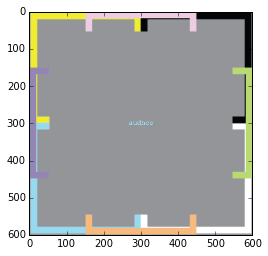

In [10]:
cond_dx = 512
img = fMRI.get_condition_stimuli(cond_dx)
plt.imshow(img)
print fMRI.stim.loc[cond_dx,'image_name']
print fMRI.stim.loc[cond_dx,'object_name']
print fMRI.stim.loc[cond_dx,'location']

#### use the imagery data for the cue model

In [11]:
idx = {}
idx['cue_img'] = fMRI.get_stimuli_with('run','img').index
idx['cue_pcp'] = fMRI.get_stimuli_with('run','pcp').index
print 'number of cue_img stimuli: %d' %(len(idx['cue_img']))
print 'number of cue_pcp stimuli: %d' %(len(idx['cue_img']))


number of cue_img stimuli: 512
number of cue_pcp stimuli: 512


### Step 1: specify gabor features

#### calculate deg_per_stimulus

In [12]:
native_stim_size = 600  ##pixels
viewing_distance = 100 ##cm
viewing_area = 38.8 ##cm

# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size)
print '%f pixels correspond to one degree' % (1./deg_per_px)
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)



27.324889 pixels correspond to one degree
The size of the stimulus is 600 pixels and 21.958003465 visual degrees


#### design gabor wavelets

In [13]:
n_orientations = 4
deg_per_stimulus = 21.958
lowest_sp_freq = .114 ##cyc/deg
highest_sp_freq = 4.5
num_sp_freq = 8
pix_per_cycle = 4.#2.13333333
complex_cell = True
n_colors = 1 ##let's do grayscale first
diams_per_filter = 4
cycles_per_radius = 2.0

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 32


In [14]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell,
                         diams_per_filter = diams_per_filter,
                         cycles_per_radius = cycles_per_radius,
                         color_channels=n_colors)

In [15]:
gfm.gbr_table.head(9)

,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.114000,16,140.350877,10.012848,64,17.543860,0.000000
1,0.192730,16,83.017792,16.927841,64,10.377224,0.000000
2,0.325831,16,49.105171,28.618412,64,6.138146,0.000000
3,0.550854,16,29.045796,48.382631,64,3.630724,0.000000
4,0.931281,16,17.180639,81.796257,64,2.147580,0.000000
5,1.574435,16,10.162379,138.285735,64,1.270297,0.000000
6,2.661758,16,6.011065,233.787525,64,0.751383,0.000000
7,4.500000,16,3.555556,395.244000,64,0.444444,0.000000
8,0.114000,16,140.350877,10.012848,64,17.543860,0.785398


In [16]:
gfm.filter_stack.shape

(32, 1, 63, 63)

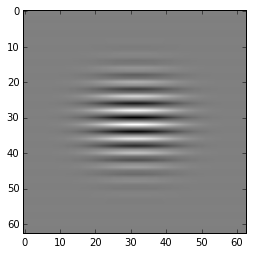

In [17]:
o =  1##choose an orientation
plt.imshow(np.imag(gfm.filter_stack[o,0,:,:]), cmap='gray')

### Step 2: Design receptive field grid

In [18]:
deg_per_radius = (1., 10., 4) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 2. ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [19]:
rf.rf_table.deg_per_radius.unique()

array([  1.,   4.,   7.,  10.])

In [20]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 400


### Step 3: Construct a model space

#### specify activation function

In [21]:
def log_act_func(x):
    return np.log(1+np.sqrt(x))


#### instantiate a model space object

In [22]:
##just read in one image for now to create the feature dictionary that will initiate the model_space object
if n_colors < 3:
    ##np.newaxis,np.newaxis = time,color
    init_image = np.array(fMRI.get_condition_stimuli(0,output = 'PIL').convert('L'))[np.newaxis,np.newaxis] 
else:
    init_image = fMRI.get_condition_stimuli(0)
    init_image = np.rollaxis(init_image,axis=2,start=0)[np.newaxis] ##<<newaxis for time only

init_feature_dict = gfm.create_feature_maps(init_image)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.008999 s.
feature 1 took 0.003226 s.
feature 2 took 0.003673 s.
feature 3 took 0.004333 s.
feature 4 took 0.006012 s.
feature 5 took 0.009954 s.
feature 6 took 0.028214 s.
feature 7 took 0.097794 s.
feature 8 took 0.001339 s.
feature 9 took 0.001544 s.
feature 10 took 0.001985 s.
feature 11 took 0.002799 s.
feature 12 took 0.005445 s.
feature 13 took 0.009881 s.
feature 14 took 0.026651 s.
feature 15 took 0.096368 s.
feature 16 took 0.001273 s.
feature 17 took 0.001541 s.
feature 18 took 0.001970 s.
feature 19 took 0.002764 s.
feature 20 took 0.005111 s.
feature 21 took 0.011920 s.
feature 22 took 0.025791 s.
feature 23 took 0.087402 s.
feature 24 took 0.001301 s.
feature 25 took 0.001507 s.
feature 26 took 0.001968 s.
feature 27 took 0.002764 s.
feature 28 took 0.005353 s.
feature 29 took 0.010134 s.
feature 30 took 0.024959 s.
feature 31 took 0.093549 s.


In [23]:
init_image.shape

(1, 1, 600, 600)

In [24]:
ms = {}
ms['cue_img'] = model_space(init_feature_dict, rf, activation_function = log_act_func)
ms['cue_pcp'] = model_space(init_feature_dict, rf, activation_function = log_act_func)


### Step 4: load up all stimuli at the max feature resolution

In [26]:
max_feature_res = np.max(ms['cue_pcp'].feature_resolutions.values())

load_stim_func = lambda dx: np.array(fMRI.get_condition_stimuli(dx,output = 'PIL',image_size=(max_feature_res,max_feature_res)).convert('L'))[np.newaxis,np.newaxis] 

In [27]:
load_stim_func(0).shape

(1, 1, 395, 395)

In [28]:
stimuli = {}
stimuli['cue_img'] = np.concatenate(map(load_stim_func,
                                 idx['cue_img']),
                             axis=0)
stimuli['cue_pcp'] = np.concatenate(map(load_stim_func,
                                 idx['cue_pcp']),
                             axis=0)


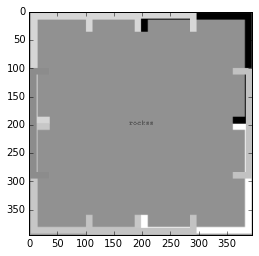

In [29]:
plt.imshow(stimuli['cue_img'][500,0,:,:], cmap='gray')

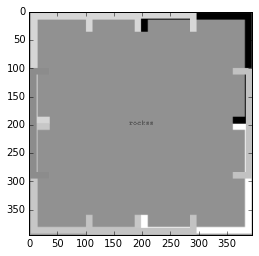

In [30]:
plt.imshow(stimuli['cue_pcp'][500,0,:,:], cmap='gray')

### Step 5: train the perception and imagery models

#### optional: select some known good voxels from the previous imagery runs

In [ ]:
# saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'


# saving_file = 'model_space_'+'fwrf_gabor_robust_'+'img'+'_'+subject+'.p'
# img_val_cc=pickle.load(open( join(saving_place, saving_file), "r")).val_cc

In [ ]:
# count_thresh = .15
# selected_voxels = np.where(map(lambda x: x > count_thresh, img_val_cc))[0]
# print len(selected_voxels)

In [ ]:
# plt.figure(figsize=(10,5))
# plt.subplot(2,1,1)
# _=plt.hist(img_val_cc[selected_voxels],100,log=True)
# plt.ylim([10**0, 10**5])
# plt.xlim([-.5, 1.])


#### train/test split

In [31]:
val_frac = 0.04687  ##24
nvox = fMRI.betas.shape[0] #len(selected_voxels)
selected_voxels = range(nvox)
n_resamples = 10 ##for a total of 240 validation samples

#### train the model!

In [32]:


mst = {}
params = {}
pred = {}
val_cc = {}
val_idx = {}
trn_idx = {}
for state in state_list: 
    params[state] = {}
    print '==========================================================%s' %(state)
    ##build feature diction. overwrite across state
    feature_dict = gfm.create_feature_maps(stimuli[state])
    ##build model space tensor
    mst[state] = ms[state].construct_model_space_tensor(feature_dict, normalize=False)
    mst[state] = ms[state].normalize_model_space_tensor(mst[state],save=True)
    voxel_data = fMRI.betas[selected_voxels, :][:,idx[state]].T
    val_idx[state] = split_em_up(len(idx[state]),val_frac,n_resamples)
    

    trn_idx[state], params[state] = leave_k_out_training(val_idx[state],
                                                         mst[state],
                                                         voxel_data,
                                                         initial_feature_weights='zeros',
                                                         voxel_binsize = 25000,
                                                         rf_grid_binsize=10,
                                                         learning_rate=10**(-5.),
                                                         max_iters = 75,
                                                         early_stop_fraction=0.05,
                                                         report_every = 25)
    ##generate predictions
    Tval = len(val_idx[state][0])
    pred[state] = np.zeros((Tval*n_resamples,nvox))
    val_cc[state] = np.zeros(nvox)

    for val_iter in val_idx[state].keys():
        frf = params[state][val_iter]['frf']
        ffw = params[state][val_iter]['ffw']
        
        for v in range(nvox): 
            pred[state][(val_iter*Tval):(val_iter*Tval+Tval),v] = np.squeeze(bigmult(mst[state][np.newaxis,frf[v],val_idx[state][val_iter],:],
                                           ffw[np.newaxis,:,v, np.newaxis]))
    
    total_val_idx = np.concatenate(val_idx[state].values()).astype('int')    
    for v in range(nvox): 
        val_cc[state][v] = np.nan_to_num(pearsonr(voxel_data[total_val_idx,v],pred[state][:,v])[0])

==========================================================cue_img
allocating memory for feature maps
constructing feature maps
feature 0 took 0.085083 s.
feature 1 took 0.170672 s.
feature 2 took 0.449914 s.
feature 3 took 0.876596 s.
feature 4 took 1.862177 s.
feature 5 took 4.161617 s.
feature 6 took 11.917734 s.
feature 7 took 44.771623 s.
feature 8 took 0.078295 s.
feature 9 took 0.159433 s.
feature 10 took 0.372969 s.
feature 11 took 0.875113 s.
feature 12 took 1.861697 s.
feature 13 took 4.149519 s.
feature 14 took 11.994107 s.
feature 15 took 45.180593 s.
feature 16 took 0.078485 s.
feature 17 took 0.160244 s.
feature 18 took 0.377144 s.
feature 19 took 0.877784 s.
feature 20 took 1.864717 s.
feature 21 took 4.150584 s.
feature 22 took 12.102512 s.
feature 23 took 44.125343 s.
feature 24 took 0.077704 s.
feature 25 took 0.156295 s.
feature 26 took 0.376231 s.
feature 27 took 0.876027 s.
feature 28 took 1.862412 s.
feature 29 took 4.147149 s.
feature 30 took 11.989063 s.
feature 

#### save it

In [33]:
saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'

for ii,state in enumerate(state_list):
    saving_file = 'model_space_'+'fwrf_gabor_robust_'+state+'_'+subject+'.p'
    ms[state].params = params[state]
    ms[state].val_cc = val_cc[state]
    ms[state].gbr = gfm
    ms[state].val_idx = val_idx[state]
    ms[state].selected_voxels = selected_voxels
    ms[state].activation_function = log_act_func
    pickle.dump(ms[state], open( join(saving_place, saving_file), "wb"))

### Step 6: analysis

#### loss history

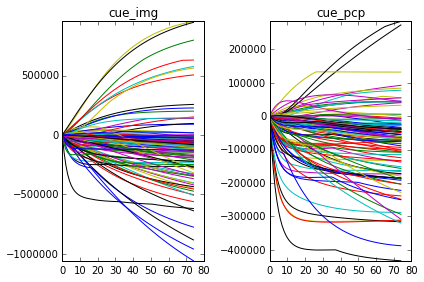

In [35]:
skip = 1
for ii,state in enumerate(state_list):
    beh = params[state][0]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    diff = beh[:,slice(0,-1,skip)]-beh[0,slice(0,-1,skip)]
    _=plt.plot(diff)
    plt.ylim([np.min(diff.ravel()),np.max(diff.ravel())])
plt.tight_layout()

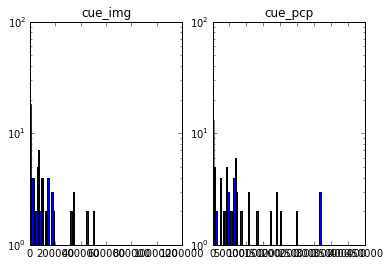

In [36]:
for ii,state in enumerate(state_list):
    beh = params[state][0]['beh']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    _=plt.hist(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)),100)
    plt.yscale('log')

#### rf's

In [ ]:
for ii,state in enumerate(state_list):
    frf = ms[state].params[0]['frf']
    plt.subplot(1,2,ii+1)
    _=plt.hist(frf,ms[state].receptive_fields.G,log=True)
    plt.xlabel('smaller-->bigger')
    plt.title(state)

In [ ]:
for ii,state in enumerate(state_list):
    frf = params[state][9]['frf']
    plt.subplot(1,2,ii+1)
    plt.title(state)
    plt.imshow(np.sum(ms[state].receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy histograms

In [ ]:
####USE THIS TO LOAD UP A SAVED MST FOR VAL_CC ANALYSIS
# state_list = ['pcp', 'img']
# saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'
# mst={}
# for ii,state in enumerate(['pcp','img']):
#     saving_file = 'model_space_'+'fwrf_gabor_robust_'+state+'_'+'CO'+'.p'
#     mst[state]=pickle.load(open( join(saving_place, saving_file), "r"))

# val_cc = {}    
# val_cc['pcp'] = mst['pcp'].val_cc

# val_cc['img'] = mst['img'].val_cc

number of voxels with cc > 0.250000, cue_img: 0
number of voxels with cc > 0.250000, cue_pcp: 1


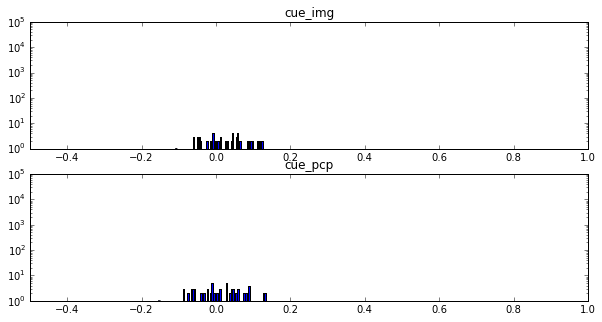

In [37]:
count_thresh = .25
plt.figure(figsize = (10,5))
for ii,state in enumerate(state_list):#, 'img']):
    plt.subplot(2,1,ii+1)
    _=plt.hist(val_cc[state],100)
    plt.yscale('log')
    plt.ylim([10**0, 10**5])
    plt.xlim([-.5, 1.])
    plt.title(state)
    print 'number of voxels with cc > %f, %s: %d' %(count_thresh,state,np.sum(map(lambda x: x > count_thresh, val_cc[state])))

#### prediction accuracy head-to-head

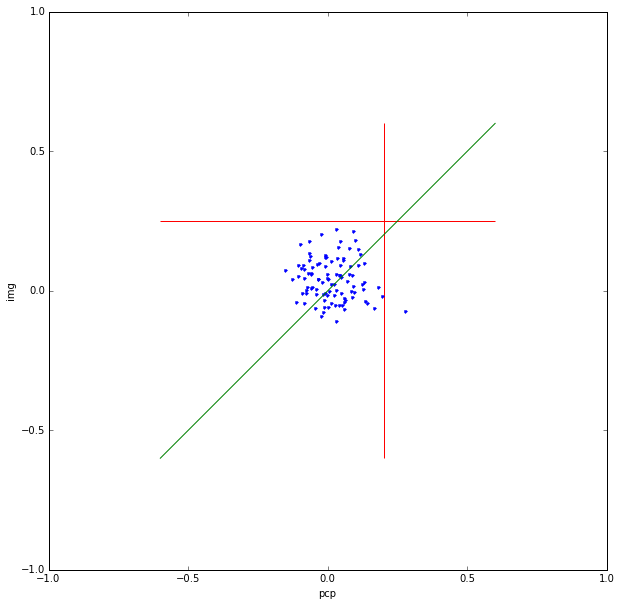

In [40]:

plt.figure(figsize=(10,10))
rng = np.linspace(-.6, .6, num=50)
plt.plot(val_cc['cue_pcp'], val_cc['cue_img'], '.');
plt.ylabel('img')
plt.xlabel('pcp')
plt.plot(rng, rng)
plt.axes().set_aspect(1)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.hlines(.25, rng[0], rng[-1], colors='r')
plt.vlines(.2, rng[0], rng[-1], colors='r')


#### prediction accuracy volumes

In [ ]:
def view_vol_data(data_object, data_vol,save_to = None):
    cur = data_object.mask.ravel(order=data_object.order).copy()
    cur[cur > 0] = data_vol
    view_vol = cur.reshape(data_object.shape,order=data_object.order)
    if save_to:
        nib.save(nib.Nifti1Image(view_vol,affine=np.eye(4)),save_to)
    else:
        return view_vol

In [ ]:
for state in state_list:
    view_vol_data(fMRI,val_cc[state], save_to = '/media/tnaselar/Data/scratch/'+state+'_gabor_val_cc_'+subject )